RQ1: Is there an association between repository activity characteristics (number of commits and project age) and performance testing intensity (configured number of users and test duration) in non-trivial repositories that make use of performance testing?


In [24]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

In [25]:
DATA_DIR = "E2EGit"  # change this

repository = pd.read_csv(f"{DATA_DIR}/repository.csv")
non_trivial = pd.read_csv(f"{DATA_DIR}/non_trivial_repository.csv")

gui_repo = pd.read_csv(f"{DATA_DIR}/gui_testing_repo_details.csv")
gui_tests = pd.read_csv(f"{DATA_DIR}/gui_testing_test_details.csv")

perf_tests = pd.read_csv(f"{DATA_DIR}/performance_testing_test_details.csv")


C:\Users\lungu\AppData\Local\Temp\ipykernel_23388\82465647.py:3: DtypeWarning: Columns (6,7,8,9,14,15,16,24,25,26,31,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  repository = pd.read_csv(f"{DATA_DIR}/repository.csv")


In [26]:
repository = repository.rename(columns={"name": "repository_name"})
non_trivial = non_trivial.rename(columns={"name": "repository_name"})

def normalize_repo(name):
    return (
        str(name)
        .replace("https://github.com/", "")
        .strip()
        .lower()
    )

for df in [repository, non_trivial, perf_tests]:
    df["repository_name"] = df["repository_name"].apply(normalize_repo)


In [27]:
repos = repository.merge(
    non_trivial[["repository_name"]],
    on="repository_name",
    how="inner"
)

len(repos)


14053

In [28]:
repos["commits"] = pd.to_numeric(repos["commits"], errors="coerce")

repos["created_at"] = pd.to_datetime(repos["created_at"], errors="coerce")
reference_date = repos["created_at"].max()

repos["project_age_days"] = (
    reference_date - repos["created_at"]
).dt.days


In [36]:
import re


def extract_first_numeric(x):
    """
    Extracts the first numeric literal from a configuration string.
    Returns NaN if no numeric value can be resolved.
    """
    if pd.isna(x):
        return np.nan
    match = re.search(r"\d+(\.\d+)?", str(x))
    return float(match.group()) if match else np.nan


# users as numeric
perf_tests["users_numeric"] = perf_tests["number_of_users"].apply(extract_first_numeric)
perf_tests["requests_numeric"] = perf_tests["number_of_requests"].apply(extract_first_numeric)



In [37]:
perf_agg = (
    perf_tests
    .groupby("repository_name")
    .agg(
        num_perf_tests=("test_path", "count"),
        median_users=("users_numeric", "median"),
        median_requests=("requests_numeric", "median"),
        num_load_configs=("threadgroup_taskset_id", "nunique"),
    )
    .reset_index()
)


In [38]:
def zscore(series):
    series = series.astype(float)
    return (series - series.mean()) / series.std()

perf_agg["intensity_users_z"] = zscore(perf_agg["median_users"])
perf_agg["intensity_requests_z"] = zscore(perf_agg["median_requests"])

perf_agg["performance_testing_intensity"] = (
    perf_agg["intensity_users_z"] + perf_agg["intensity_requests_z"]
)


In [39]:
analysis_df = repos.merge(
    perf_agg,
    on="repository_name",
    how="inner"
)


analysis_df.head()



,repository_name,is_fork,commits,branches,releases,forks,main_language,default_branch,licences,homepage,...,labels,topics,project_age_days,num_perf_tests,median_users,median_requests,num_load_configs,intensity_users_z,intensity_requests_z,performance_testing_intensity
0,apache/roller,0.0,4755.0,21.0,1.0,124.0,Java,master,Apache License 2.0,NaN,...,ci; dependencies; ready for review; wip;,content; java; roller;,5419,1,5.0,10.0,1,-0.130824,0.064383,-0.066441
1,nysenate/openlegislation,0.0,5077.0,17.0,1.0,104.0,Java,dev,Other,http://legislation.nysenate.gov/,...,dependencies; java; javascript;,NaN,4970,5,1.0,1.0,5,-0.131151,-0.294217,-0.425368
2,eclipse/jetty.project,0.0,25070.0,55.0,72.0,1892.0,Java,jetty-10.0.x,Other,https://eclipse.dev/jetty,...,bad-idea; bug; build; build-all-tests; build-n...,eclipse; embedded; fcgi; http; http-client; ht...,4635,2,400.0,5.0,1,-0.098466,-0.134839,-0.233305
3,apereo/cas,0.0,24993.0,27.0,262.0,3871.0,Java,master,Apache License 2.0,https://apereo.github.io/cas/,...,acceptable usage policy; acceptto mfa; analyti...,authentication; authorization; aws; duosecurit...,4578,8,3.5,2.0,2,-0.130946,-0.254373,-0.385319
4,mapfish/mapfish-print,0.0,4550.0,17.0,39.0,412.0,Java,master,BSD 2-Clause Simplified License,http://mapfish.github.io/mapfish-print-doc/,...,backport 3.27; backport 3.28; backport 3.29; b...,geomapfish; geospatial; geotools; gis; jasperr...,4518,5,100.0,1.0,5,-0.123041,-0.294217,-0.417258


In [40]:
pairs = [
    ("commits", "performance_testing_intensity"),
    ("project_age_days", "performance_testing_intensity"),
]

results = []
for x, y in pairs:
    rho, p = spearmanr(analysis_df[x], analysis_df[y], nan_policy="omit")
    results.append({
        "x": x,
        "y": y,
        "spearman_rho": rho,
        "p_value": p
    })

correlation_results = pd.DataFrame(results)
correlation_results


,x,y,spearman_rho,p_value
0,commits,performance_testing_intensity,0.001959,0.987446
1,project_age_days,performance_testing_intensity,-0.042815,0.730832


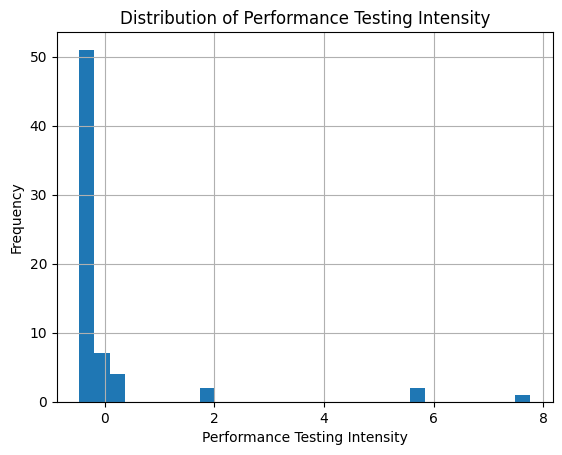

In [41]:
import matplotlib.pyplot as plt

analysis_df["performance_testing_intensity"].hist(bins=30)
plt.xlabel("Performance Testing Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of Performance Testing Intensity")
plt.show()


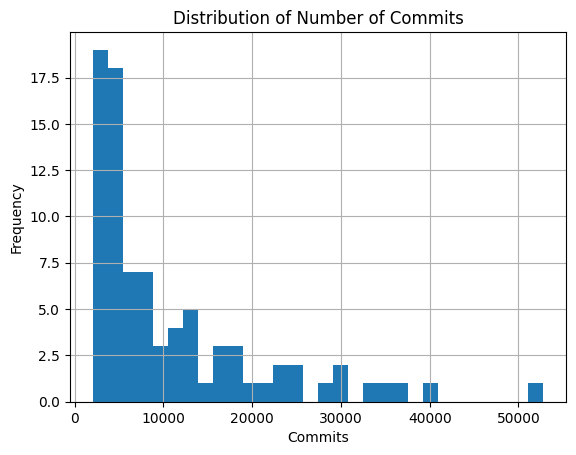

In [42]:
analysis_df["commits"].hist(bins=30)
plt.xlabel("Commits")
plt.ylabel("Frequency")
plt.title("Distribution of Number of Commits")
plt.show()


In [43]:
analysis_df[[
    "commits",
    "project_age_days",
    "performance_testing_intensity"
]].skew()


commits                          1.796559
project_age_days                 0.045312
performance_testing_intensity    4.184264
dtype: float64